# Часть 1. Проект. Методы uplift-моделирования в Яндекс Еде.

#### **Задача**

Определить целевую аудиторию, которой можно предложить промокод на 500 рублей на доставку еды из ресторанов. Цель этого предложения — побудить пользователей совершать покупки чаще. Конверсией в таком контексте можно считать успешное использование промокода, ведь тогда частота заказов увеличится, а доход компании возрастёт.

#### **Бизнес-задача**

Разработать эффективную систему, которая позволит точно идентифицировать нужную целевую аудиторию. Это повысит конверсию использования промокодов и приведёт к увеличению доходов компании.

***Цель проекта*** — создать с нуля uplift-модель на основе данных A/B-теста. Она поможет точнее выбирать клиентов, которым действительно стоит предлагать промокоды. Это не только повысит конверсию, но и улучшит финальные показатели бизнеса.

#### **Задача машинного обучения**

ML-задача — построить модель, которая наиболее точно оценивает, как предложение промокода влияет на вероятность оформления заказа у каждого пользователя.

## Этап 1. Первичная подготовка данных

Необходимо:
- импортировать необходимые библиотеки для работы с данными и визуализацией;
- загрузить датасет;
- заполнить пропуски в датасете, если они есть.

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# загружаем данные
data = pd.read_csv("uplift_fp_data.csv")

grouped_data = (
    data.groupby("treatment")["target"].agg(["mean","count"])
)
print(data.info())
print(grouped_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  int64  
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  int64  
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  int64  
 8   treatment        64000 non-null  int64  
 9   target           64000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.9 MB
None
               mean  count
treatment                 
0          0.144463  42613
1          0.151400  21387


На этапе первичной подготовки данных был загружен датасет uplift_fp_data.csv.

Проверка структуры данных показала, что:
- датасет содержит 64 000 наблюдений и 10 признаков
- пропущенные значения отсутствуют во всех столбцах
- все признаки имеют корректные числовые типы данных (int64, float64)
- переменные treatment и target являются бинарными.

Агрегация целевой переменной по группам воздействия показала различие средних значений:
- для контрольной группы (treatment = 0) среднее значение target ≈ 0.144;
- для тестовой группы (treatment = 1) среднее значение target ≈ 0.151.
- В среднем промокод увеличивает конверсию на 0.7п.п(0.151400 − 0.144463 = 0.006937) или 4.8%(0.006937 / 0.144463).

В среднем воздействие приводит к увеличению конверсии на ~0.7 п.п. Эффект невелик по величине, однако его наличие делает задачу релевантной для uplift-моделирования, целью которого является поиск сегментов пользователей с наибольшей чувствительностью к воздействию.

## Этап 2. Проведение исследовательского анализа данных

### EDA


In [15]:
# проверка размеров групп
target_sizes = data["target"].value_counts(normalize=True)
group_sizes = data["treatment"].value_counts(normalize=True)
print(target_sizes)
print(group_sizes)

# Проверка баланса групп
crosstab = pd.crosstab(data["treatment"], data["target"], normalize="index")
print(crosstab)

target
0    0.853219
1    0.146781
Name: proportion, dtype: float64
treatment
0    0.665828
1    0.334172
Name: proportion, dtype: float64
target            0         1
treatment                    
0          0.855537  0.144463
1          0.848600  0.151400


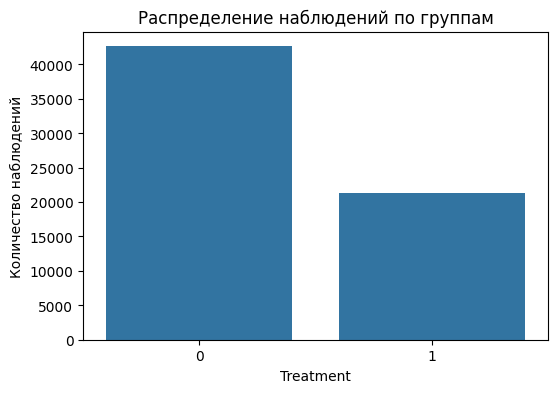

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="treatment")
plt.title("Распределение наблюдений по группам")
plt.xlabel("Treatment")
plt.ylabel("Количество наблюдений")
plt.show()

**Вывод по сбалансированности выборки и распределению таргета**

Выборка несбалансирована по группам воздействия: контрольная группа составляет около 66.6%, тестовая — 33.4% наблюдений. Это допустимо и типично для маркетинговых A/B-экспериментов, однако данный факт следует учитывать при дальнейшем моделировании.

Целевая переменная также несбалансирована: положительный исход наблюдается примерно в 14.7% случаев, что указывает на редкое событие.

При этом распределение таргета внутри групп воздействия сопоставимо:
- в контрольной группе конверсия составляет 14.45%,
- в тестовой — 15.14%.

Разница между группами невелика, но направлена в сторону тестовой группы, что указывает на слабый положительный эффект воздействия и подтверждает корректность постановки задачи uplift-моделирования.

### Проверка на статистическую значимость

In [ ]:
# Подготовка данных

control = data[data["treatment"] == 0]["target"]
treatment = data[data["treatment"] == 1]["target"]

print("Control mean:", control.mean())
print("Treatment mean:", treatment.mean())
print("Control std:", control.std())
print("Treatment std:", treatment.std())

Control mean: 0.14446295731349587
Treatment mean: 0.151400383410483
Control std: 0.3515626711050198
Treatment std: 0.3584470880102957


Данные были разделены на две независимые группы:
- контрольная группа (treatment = 0)
- тестовая группа (treatment = 1).

Для обеих групп были рассчитаны средние значения и стандартные отклонения целевой переменной target.

**Вывод:**
Среднее значение таргета в тестовой группе (0.1514) выше, чем в контрольной (0.1445), при сопоставимых значениях стандартного отклонения. Это указывает на потенциальный положительный эффект воздействия, который требует статистической проверки.

In [ ]:
# Проверка нормальности распределений (быстрая sanity-check)
from scipy.stats import shapiro

shapiro_control = shapiro(control.sample(5000, random_state=42))
shapiro_treatment = shapiro(treatment.sample(5000, random_state=42))

print("Shapiro control p-value:", shapiro_control.pvalue)
print("Shapiro treatment p-value:", shapiro_treatment.pvalue)

Shapiro control p-value: 2.089045399207799e-83
Shapiro treatment p-value: 9.42375526131186e-83


Для оценки предпосылок параметрических тестов была выполнена проверка нормальности распределения целевой переменной с помощью теста Шапиро–Уилка на случайной подвыборке.

**Результат:**

p-value для обеих групп значительно меньше 0.05, это указывает на статистически значимые различия между группами.

**Вывод:**

Проверка нормальности распределений с помощью теста Шапиро–Уилка показала, что распределения целевой переменной в контрольной и тестовой группах не являются нормальными (p-value ≪ 0.05), что ожидаемо для бинарной целевой переменной. Однако, с учётом большого объёма выборки, для сравнения средних был применён t-тест для независимых выборок, так как центральная предельная теорема обеспечивает корректность его применения.

In [24]:
# t-тест для независимых выборок

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    treatment,
    control,
    equal_var=False
)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 2.3243826621990147
p-value: 0.020109726914857923


Для проверки гипотезы о равенстве средних была использована t-проверка Стьюдента для независимых выборок с неравными дисперсиями (Welch’s t-test).

Обоснование выбора теста:
- группы независимы;
- сравниваются средние значения бинарной целевой переменной;
- дисперсии в группах могут отличаться;
- большой объём данных делает t-тест устойчивым к нарушению нормальности.

Так как p-value < 0.05, нулевая гипотеза о равенстве средних отвергается.

**Вывод:**

Различие между контрольной и тестовой группами является статистически значимым, несмотря на небольшой абсолютный эффект.

## Построение корреляций

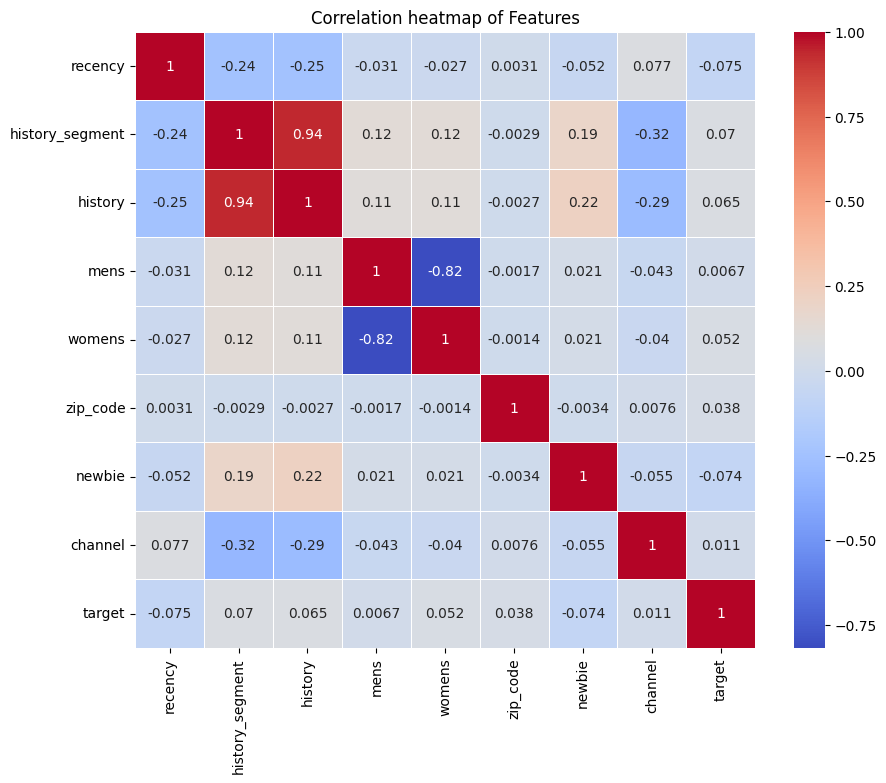

In [26]:
# Корреляционная матрица

corr_matrix = (data
                .drop(columns=['treatment'])
                .corr()
            )

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation heatmap of Features")
plt.show()

In [27]:
# Корреляция признаков с таргетом

target_corr = corr_matrix["target"].sort_values(ascending=False)
print(target_corr)

target             1.000000
history_segment    0.069734
history            0.065153
womens             0.051999
zip_code           0.037570
channel            0.010584
mens               0.006712
newbie            -0.073924
recency           -0.074765
Name: target, dtype: float64


**Корреляции между признаками**

- Наблюдается очень высокая положительная корреляция между признаками history_segment и history (≈ 0.94).
Это ожидаемо, так как history_segment является дискретизированным представлением суммарной истории покупок (history).
В дальнейшем это стоит учитывать как потенциальную мультиколлинеарность.
- Признаки mens и womens имеют сильную отрицательную корреляцию (≈ -0.82), что логично: пользователь, как правило, ориентирован либо на мужскую, либо на женскую категорию.
- Остальные пары признаков демонстрируют слабые или умеренные корреляции, что говорит об отсутствии сильной линейной зависимости между большинством фич.

**Корреляции признаков с целевой переменной**

- Ни один из признаков не имеет сильной линейной корреляции с таргетом.
- Признаки recency и newbie имеют слабую отрицательную корреляцию с таргетом.

Это указывает на то, что:
- поведение пользователей определяется нелинейными и комбинированными эффектами признаков
- простые линейные модели могут быть недостаточно выразительными
- использование деревьев решений, ансамблей или uplift-алгоритмов является обоснованным.

**Общий вывод корреляционного анализа:**

Корреляционный анализ показал отсутствие сильных линейных зависимостей между признаками и целевой переменной, а также выявил несколько логичных зависимостей между самими признаками (например, history и history_segment, mens и womens). Это подтверждает, что для данной задачи целесообразно использовать модели, способные улавливать сложные нелинейные взаимодействия, в том числе специализированные uplift-модели.

### **Саммари по этапу 2:**

В ходе исследовательского анализа данных было выявлено, что выборка умеренно несбалансирована по группам воздействия, однако распределение целевой переменной в контрольной и тестовой группах является сопоставимым. Проведённая статистическая проверка показала небольшой, но статистически значимый положительный эффект воздействия.

Корреляционный анализ не выявил сильных линейных зависимостей между признаками и целевой переменной, что указывает на ограниченную информативность простых линейных моделей. Это обосновывает целесообразность применения более гибких подходов, способных учитывать сложные и нелинейные взаимодействия, включая uplift-моделирование (например, RandomForest, XGBoost, uplift-деревья).

Подробнее в файле *summary_eda_p1s2.md*.

## Этап 3

Обоснуйте выбор конкретной uplift модели в данной ячейке

### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

### Обучение выбранного бейзлайна

### Расчет метрик для выбранного бейзлайна на тестовой выборке

# Обучение 2 моделей 

### Обучение модели 1

### Получение метрик по модели 1

### Обучение модели 2

### Получение метрик по модели 2

Проинтерпретируйте полученные результаты и обоснуйте выбор 1 модели в этой ячейке

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

#### Генерация признаков (опционально)

### Подбор гиперпараметров

In [ ]:
from optuna import create_study
from sklift.metrics import uplift_at_k

def objective(trial):
    # Дополните код для подбора гиперпараметров

    uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
    return uplift_at_30

# Создаем и запускаем исследование
study = create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Выводим лучшие гиперпараметры
print("Best hyperparameters: ", study.best_params)
print("Best score: ", study.best_value)


## Этап 2

### Визуализация результатов

In [ ]:
from utils import custom_uplift_by_percentile

В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

# Этап 3

In [138]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # реализуйте преобразование данных для модели,
        # если в финальной модели используются новые признаки
       

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        

        # Дополните код для получения предсказаний аплифта

        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [126]:
model = UpliftModelInference(model= # ваш код,
                             feature_names= # ваш код)

In [ ]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [ ]:
# проверка работы класса
model.predict(test_data)